# Prep

## Dependencies

In [1]:
# General
import os
from os import path
import shutil
import glob
from datetime import datetime
from tqdm.notebook import tqdm

# Data processing
import pandas as pd
import numpy as np

# Keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

# ScikitLearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    auc,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay)

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Images
import cv2

2023-04-25 17:26:01.608042: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 17:26:06.675667: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-04-25 17:26:06.675896: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

## Constants

In [2]:
CLASSES = ["normal", "covid"] # In order, first = 0, then 1, etc.
NUM_EPOCHS = 60
VALID_SPLIT = 0.2
LABEL_COLUMN = 'label'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
RANDOM_STATE = 41
LEARNING_RATE = 0.0001
OUT_MODEL_PATH = "./models"

## Prepare Dataset

In [3]:
# Get paths
raw_data_path = path.join(os.getcwd(), "data")
train_data_path = path.join(raw_data_path, "train")
test_data_path = path.join(raw_data_path, "test")

In [4]:
def get_image_df(data_path, labels_filter=CLASSES):
    labels = os.listdir(data_path)
    columns = ["image_path", LABEL_COLUMN]
    
    images = []
    for label in labels:
        if label not in labels_filter:
            continue
        label_image_paths = os.listdir(path.join(data_path, label))
        label_images = list(map(lambda im_path: [f"{label}/{im_path}", label], label_image_paths))
        images.extend(label_images)
        
    return pd.DataFrame(images, columns=columns)
        
train_df = get_image_df(train_data_path)
test_df = get_image_df(test_data_path)
display(train_df.sample(5).head())
display(test_df.sample(5).head())

,image_path,label
212,covid/train-0734.png,covid
391,covid/train-0432.png,covid
456,covid/train-0137.png,covid
644,normal/train-0282.png,normal
724,normal/train-0562.png,normal


,image_path,label
0,covid/test-0029.png,covid
84,normal/test-0049.png,normal
53,normal/test-0070.png,normal
4,covid/test-0068.png,covid
112,normal/test-0002.png,normal


In [5]:
# Stratify split test dataset into test and validation
train_df, valid_df = train_test_split(train_df,
                                     test_size=VALID_SPLIT,
                                     shuffle=True,
                                     stratify=train_df[LABEL_COLUMN],
                                     random_state=RANDOM_STATE
                                    )

## Load Dataset

In [6]:
# No preprocessing for this paper
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                   # rotation_range=50,
                                   # featurewise_center = True,
                                   # featurewise_std_normalization = True,
                                   # width_shift_range=0.2,
                                   # height_shift_range=0.2,
                                   # shear_range=0.25,
                                   # zoom_range=0.1,
                                   # zca_whitening = True,
                                   # channel_shift_range = 20,
                                   # horizontal_flip = True ,
                                   # vertical_flip = True ,
                                   # validation_split = 0.2,
                                   # fill_mode='constant'
                            )


flow_kwargs = {
    # 'directory': train_data_path,
    'x_col': 'image_path',
    'y_col': LABEL_COLUMN,
    'batch_size': BATCH_SIZE,
    'seed': RANDOM_STATE,
    'class_mode': 'categorical',
    'classes': CLASSES,
    'target_size': IMAGE_SIZE
}

#Test Datagen only rescales for model
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


train_batches = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                  directory=train_data_path, shuffle=True, **flow_kwargs)

valid_batches = train_datagen.flow_from_dataframe(dataframe=valid_df,
                                                  directory=train_data_path, shuffle=False, **flow_kwargs)

test_batches = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                directory=test_data_path, shuffle=False, **flow_kwargs)

DATASETS = {
    'train': train_batches,
    "validation": valid_batches,
    'test': test_batches,
}

Found 710 validated image filenames belonging to 2 classes.
Found 178 validated image filenames belonging to 2 classes.
Found 118 validated image filenames belonging to 2 classes.


# EDA

In [7]:
print(train_batches.class_indices)

{'normal': 0, 'covid': 1}


In [8]:
print(f"Train dataset length: {len(train_df)}")
print(f"Valid dataset length: {len(valid_df)}")
print(f"Test dataset length: {len(test_df)}")

Train dataset length: 710
Valid dataset length: 178
Test dataset length: 118


In [9]:
xb, yb = train_batches.next()
xb.shape,yb.shape

((16, 224, 224, 3), (16, 2))

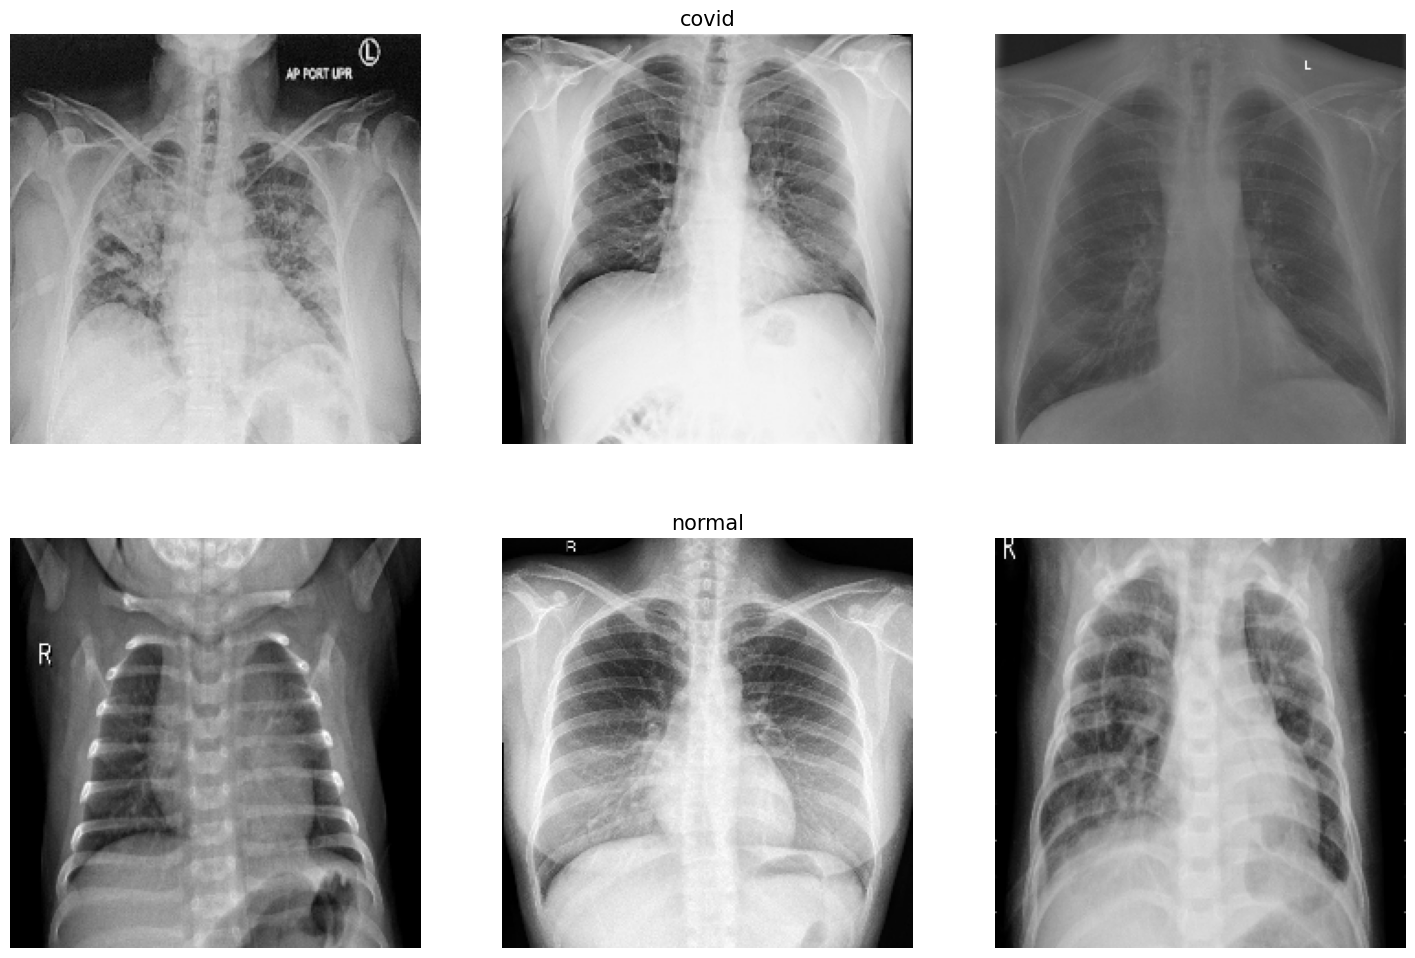

In [10]:
def display_class_sample(df, data_path, num_samples_per_class=3, middle_image=1):
    fig, axs = plt.subplots(2, num_samples_per_class, figsize = (6*num_samples_per_class, 3*4))

    for ax_row, (label, data) in zip(axs, df.sort_values([LABEL_COLUMN]).groupby(LABEL_COLUMN)):
        ax_row[middle_image].set_title(label, fontsize = 15)
        for ax, (idx, instance) in zip(ax_row, data.sample(num_samples_per_class).iterrows()):       
            _path = path.join(data_path, instance['image_path'])
            image = cv2.imread(_path)
            ax.imshow(image)
            ax.axis('off')

display_class_sample(train_df, train_data_path)

# Train Model

## Build Three Models for Ensemble

In [11]:
def build_model(model_name, summary=False):
    base_model = None
    model_map = {
        'resnet50_v2': tf.keras.applications.ResNet50V2,
        'inception_v3': tf.keras.applications.InceptionV3,
        'densenet201': tf.keras.applications.DenseNet201,
    }

    base_model = model_map[model_name](weights=None, include_top=False, input_shape= (*IMAGE_SIZE, 3))
    
    x = base_model.output         
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output = tf.keras.layers.Dense(len(CLASSES), activation=None)(x)
    model = tf.keras.Model(inputs = base_model.input, outputs = output)
    

    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

    model.compile(optimizer = optimizer,
                  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics = ['accuracy'])
    if summary:
        print(model.summary())
    return model

## Fit Model

In [12]:
def train_model_and_save_results(model, *args, name=None, out_path=OUT_MODEL_PATH, out_time=None, save_final=True, **kwargs):
    if not name:
        raise Exception("Must supply name when training multiple models")
        
    if not out_time:
        out_time = datetime.now()
    out_path = path.join(out_path, out_time.strftime("%Y-%m-%dT%H:%M"))
    os.makedirs(out_path, exist_ok=True)
    
    save_model = tf.keras.callbacks.ModelCheckpoint(
        f"{out_path}/"+name+ "-{epoch:04d}-{accuracy:.2f}.tf",
        monitor = "val_loss",
        mode='min',
        verbose=0,
        save_weights_only=True,
        save_best_only=True
    )
    history_logger = tf.keras.callbacks.CSVLogger(path.join(out_path, name+"-train-log.csv"), separator=",", append=False)
    callbacks=kwargs.pop("callbacks", [])
    callbacks.append(save_model)
    callbacks.append(history_logger)

    history = model.fit(callbacks=callbacks, *args, **kwargs)
    np.save(path.join(out_path, name+ "-history.npy"), history.history)
    
    # Save final model
    last_accuracy = history.history['accuracy'][-1]
    final_out_path = f"{out_path}/" + name +"-last-{accuracy:.2f}.tf".format(accuracy=last_accuracy)
    model.save_weights(final_out_path)
    
    return history.history

In [13]:
def train_model(model, name, out_time=None, **kwargs):
    history = train_model_and_save_results(model, train_batches,
                                 name=name,
                                 out_time=out_time,
                                 validation_data=valid_batches,
                                 epochs=NUM_EPOCHS,
                                 workers=1, 
                                 **kwargs)
                                 # class_weight=class_weights)
    return history

def load_model(model, model_path, checkpoint_name, history_name="history.npy"):
    model_path = path.join(OUT_MODEL_PATH, model_path)
    checkpoint_path = path.join(model_path, checkpoint_name)
    history_path = path.join(model_path, history_name)
    model.load_weights(checkpoint_path)
    history = np.load(history_path, allow_pickle='TRUE').item()
    return history
    
def train_together():
    """
    Only used to synchronize clocks for output models into the same folder
    """
    out_time = datetime.now()
    
    try:
        inception_model = build_model('inception_v3')
        inception_history = train_model(inception_model, "inception", out_time=out_time)
    except Exception as e:
        print("Failed to train inception" + e)
    
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, 
                           mode='min', restore_best_weights=True)]
    try:
        densenet_model = build_model('densenet201')
        densenet_history = train_model(densenet_model, "densenet", callbacks=callbacks, out_time=out_time)
    except Exception as e:
        print("Failed to train densenet" + e)
    
    try:
        resnet_model = build_model('resnet50_v2')
        resnet_history = train_model(resnet_model, "resnet", callbacks=callbacks, out_time=out_time)
    except Exception as e:
        print("Failed to train resnet" + e)
    
    return inception_model, densenet_model, resnet_model, inception_history, densenet_history, resnet_history

In [14]:
LOAD_INCEPTION = True
inception_model = build_model('inception_v3')
if LOAD_INCEPTION:
    inception_history = load_model(inception_model, "2023-04-24T06:34", "inception-last-1.00.tf", history_name="inception-history.npy")
else:
    inception_history = train_model(inception_model, "inception")

2023-04-25 17:26:13.128618: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-25 17:26:13.128690: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (expensive): /proc/driver/nvidia/version does not exist
2023-04-25 17:26:13.129963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
LOAD_DENSENET = True
densenet_model = build_model('densenet201')

if LOAD_DENSENET:
    densenet_history = load_model(densenet_model, "2023-04-24T06:34", "densenet-0029-1.00.tf", history_name="densenet-history.npy")
else:
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, 
                           mode='min', restore_best_weights=True)
    densenet_history = train_model(densenet_model, "densenet", callbacks=[early_stop])

In [16]:
LOAD_RESNET = True
resnet_model = build_model('resnet50_v2')

if LOAD_RESNET:
    resnet_history = load_model(resnet_model, "2023-04-24T06:34", "resnet-last-1.00.tf", history_name="resnet-history.npy")
else:
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, 
                           mode='min', restore_best_weights=True)
    resnet_history = train_model(resnet_model, "resnet", callbacks=[early_stop]) 

In [ ]:
inception_model, densenet_model, resnet_model, inception_history, densenet_history, resnet_history = train_together()

2023-04-24 06:34:26.496136: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-24 06:34:26.496339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (expensive): /proc/driver/nvidia/version does not exist
2023-04-24 06:34:26.499889: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/60
45/45 [==============================] - 117s 2s/step - loss: 0.4001 - accuracy: 0.8254 - val_loss: 0.7178 - val_accuracy: 0.4438
Epoch 2/60
45/45 [==============================] - 92s 2s/step - loss: 0.2425 - accuracy: 0.9056 - val_loss: 0.6867 - val_accuracy: 0.5562
Epoch 3/60
45/45 [==============================] - 97s 2s/step - loss: 0.1856 - accuracy: 0.9211 - val_loss: 0.6830 - val_accuracy: 0.5562
Epoch 4/60
45/45 [==============================] - 96s 2s/step - loss: 0.1784 - accuracy: 0.9352 - val_loss: 1.1848 - val_accuracy: 0.4438
Epoch 5/60
45/45 [==============================] - 91s 2s/step - loss: 0.1098 - accuracy: 0.9577 - val_loss: 0.9381 - val_accuracy: 0.4494
Epoch 6/60
45/45 [==============================] - 97s 2s/step - loss: 0.1258 - accuracy: 0.9577 - val_loss: 0.6766 - val_accuracy: 0.6011
Epoch 7/60
45/45 [==============================] - 91s 2s/step - loss: 0.0703 - accuracy: 0.9718 - val_loss: 0.6299 - val_accuracy: 0.7191
Epoch 8/60
45/45 [=

# Evaluate

In [18]:
def get_pred_and_truth_not_shuffled(model, batches, single_binary_neuron=False):
    """
    This can only be used if the dataset is not shuffled
    """
    preds = model.predict(batches)
    if single_binary_neuron:
        # For single neuron with binary class probabily output
        y_pred = np.where(preds > 0.5, 1, 0)
    else:
        # For multi class or binary class using 2 neurons
        y_pred = np.argmax(preds, axis=-1)
    y_true = batches.classes
    return y_pred, y_true


def get_pred_and_truth(model, batches, single_binary_neuron=False, ensemble=False, ensemble_weights=None):
    """
    This is required if the dataset is shuffled. You can't use batches.classes as the indexes are all wrong.
    Instead you get each batch, one at a time and process 
    """
    if ensemble:
        assert type(model) is list, "Model should be list of models if testing an ensemble"
        assert ensemble_weights is not None, "Weights must be set for ensemble"
        assert len(ensemble_weights) == len(model), "One weight should be set for each model"

    # batches.reset()
    y_pred_batches = []  # store predicted labels
    y_true_batches = []  # store true labels
    if ensemble:
        for idx in tqdm(range(len(batches))):
            img_batch, y_batch = batches[idx]
            
            preds_batch_models = []
            for m in model: 
                preds_batch_models.append(m.predict(img_batch, verbose=0))
            
            # Resahep to get a shape we can average
            # Here we are transforming into a list, batch_size long
            # Each entry is num_models * num_classes
            preds_batch = []
            for image_idx in range(len(img_batch)):
                # For each image in batch
                image_preds_models = [] 
                for model_idx in range(len(model)):
                    # For each model, get prediction, [c1, c2] # potentialy c3, if more classes
                    image_preds_models.append(preds_batch_models[model_idx][image_idx])
    
                preds_batch.append(image_preds_models)
            
            # Get avarege of each modl 
            preds_batch = np.average(np.array(preds_batch), axis=1, weights=w)

            if single_binary_neuron:
                # For single neuron with binary class probabily output
                y_pred_batch = np.where(preds_batch > 0.5, 1, 0)
            else:
                # For multi class or binary class using 2 neurons
                y_pred_batch = np.argmax(preds_batch, axis=-1)

            y_true_batch = np.argmax(y_batch,-1)

            y_pred_batches.append(y_pred_batch)
            y_true_batches.append(y_true_batch)

    else:
        for idx in tqdm(range(len(batches))):
            img_batch, y_batch = batches[idx]

            preds_batch = model.predict(img_batch, verbose=0)

            if single_binary_neuron:
                # For single neuron with binary class probabily output
                y_pred_batch = np.where(preds_batch > 0.5, 1, 0)
            else:
                # For multi class or binary class using 2 neurons
                y_pred_batch = np.argmax(preds_batch, axis=-1)

            y_true_batch = np.argmax(y_batch,-1)


            y_pred_batches.append(y_pred_batch)
            y_true_batches.append(y_true_batch)

    y_true = tf.concat([item for item in y_true_batches], axis = 0)
    y_pred = tf.concat([item for item in y_pred_batches], axis = 0)

    return y_pred, y_true


def evaluate_metrics(name, y_pred, y_true, round_to=6, plot=True):
    # Get confusion matrix and standard metrics for display in dataframe
    # Metrics calculated with Sklearn where possible
    cm = confusion_matrix(y_true, y_pred)
    conf = ConfusionMatrixDisplay(cm)
    specificity = round((cm[0,0]/(cm[0,0] + cm[0,1])),round_to)
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    
    metrics = []
    metrics.append(["Accuracy", round(accuracy_score(y_true, y_pred),round_to)]) 
    metrics.append(["Recall", round(recall_score(y_true, y_pred),round_to)]) # TP/P
    metrics.append(["Specificity", specificity]) # TN/N
    metrics.append(["Precision", round(precision_score(y_true, y_pred),round_to)]) # TP/TP+FP
    metrics.append(["F1 Score", round(f1_score(y_true, y_pred),round_to)]) # 2 * (precision + recall) / (precison * recall)
    metrics = pd.DataFrame(data=metrics, columns=["Metric", "Score"])

    if plot:
        print(f"\n----------------------------- Classification report for {name} dataset -----------------------------\n")
        display(metrics)
        conf.plot()
        plt.show()
        roc.plot()
        plt.show()
        
    return metrics, conf

def evaluate_on_dataset(model, dataset, dataset_name, plot=True, ensemble=False, ensemble_weights=None):
    y_pred, y_true = get_pred_and_truth(model, dataset, ensemble=ensemble, ensemble_weights=ensemble_weights)
    return evaluate_metrics(dataset_name, y_pred, y_true, plot=plot)

def evaluate_on_all_datasets(model, datasets=DATASETS, ensemble=False, ensemble_weights=None):
    for name, d in datasets.items():
        metrics, conf = evaluate_on_dataset(model, d, name, plot=True, ensemble=ensemble, ensemble_weights=ensemble_weights)

def plot_loss_accuracy_curves(history, plot=True, limit_epochs=None):
    """
    Takes history.history
    """
    fig, axes = plt.subplots(1, 2, figsize=(16,8))

    
    for metric, ax in zip(['loss', 'accuracy'], axes):
        if not limit_epochs:
            limit_epochs = len(history[metric])
        ax.plot(history[metric][:limit_epochs])
        ax.plot(history[f'val_{metric}'][:limit_epochs])
        ax.set_title(f'model {metric}')
        ax.set_ylabel(metric)
        ax.set_xlabel('epoch')
        ax.legend(['train', 'val'], loc='upper left')
    plt.show()

### Inception

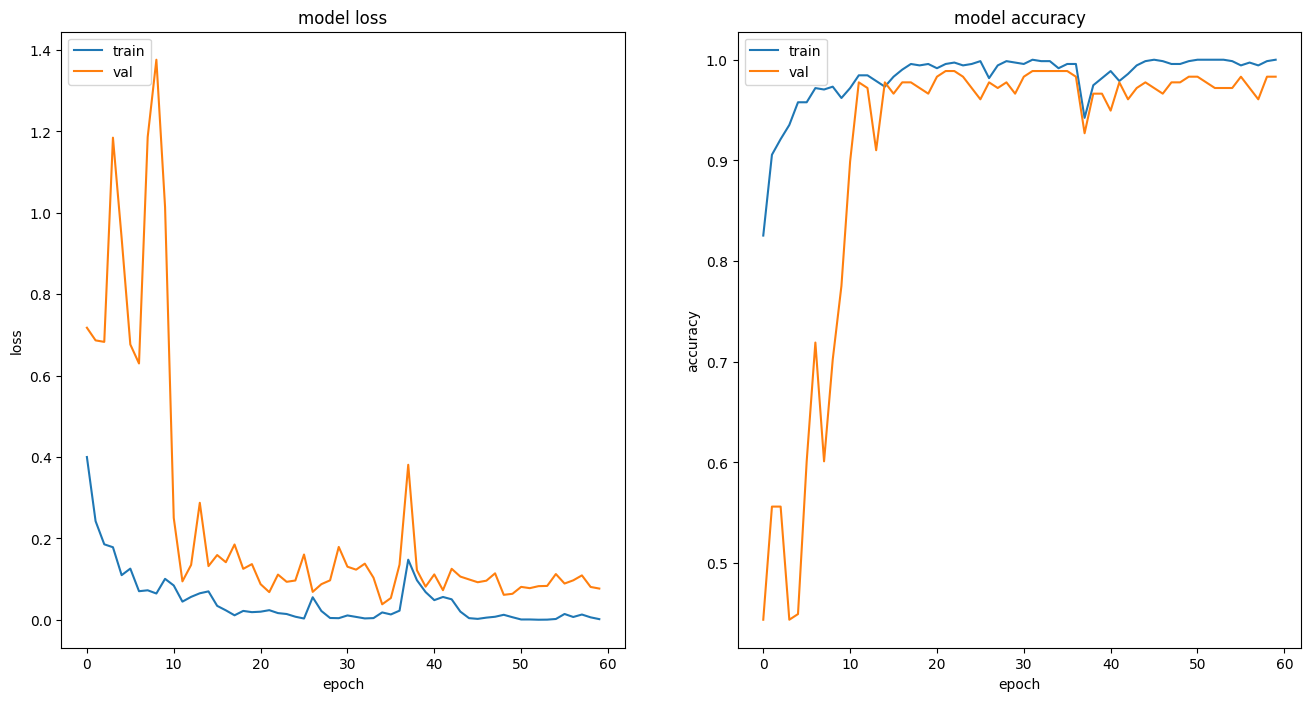

In [19]:
plot_loss_accuracy_curves(inception_history, plot=True)

  0%|          | 0/45 [00:00<?, ?it/s]


----------------------------- Classification report for train dataset -----------------------------



,Metric,Score
0,Accuracy,1.0
1,Recall,1.0
2,Specificity,1.0
3,Precision,1.0
4,F1 Score,1.0


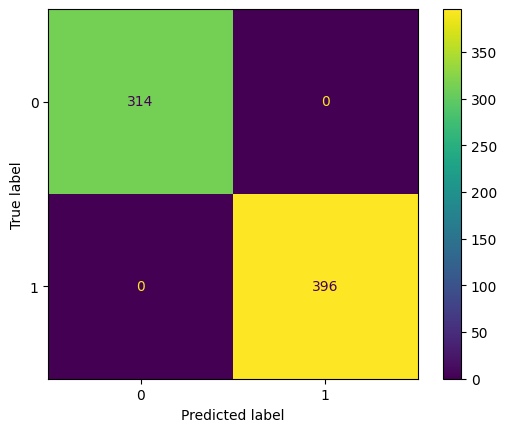

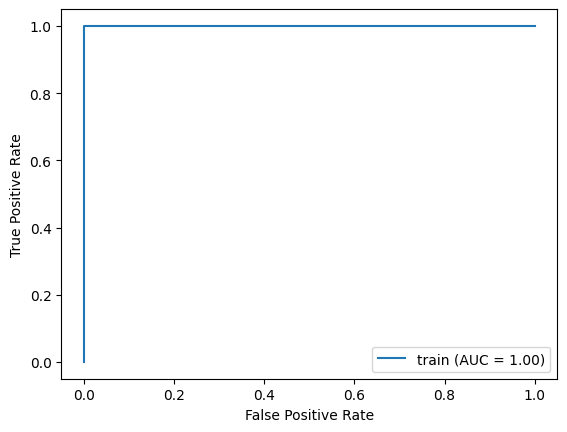

  0%|          | 0/12 [00:00<?, ?it/s]


----------------------------- Classification report for validation dataset -----------------------------



,Metric,Score
0,Accuracy,0.983146
1,Recall,0.989899
2,Specificity,0.974684
3,Precision,0.980000
4,F1 Score,0.984925


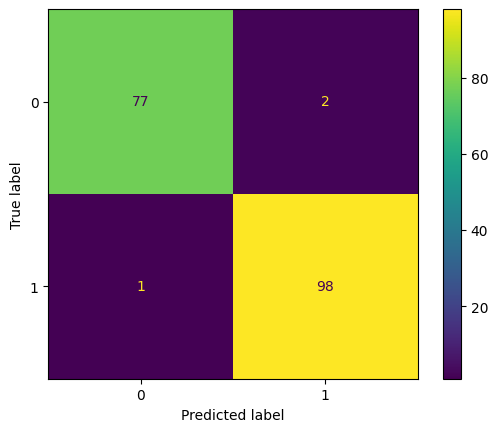

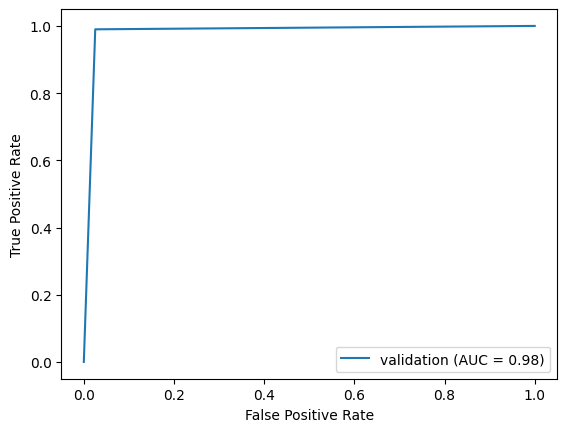

  0%|          | 0/8 [00:00<?, ?it/s]


----------------------------- Classification report for test dataset -----------------------------



,Metric,Score
0,Accuracy,0.966102
1,Recall,0.953488
2,Specificity,0.973333
3,Precision,0.953488
4,F1 Score,0.953488


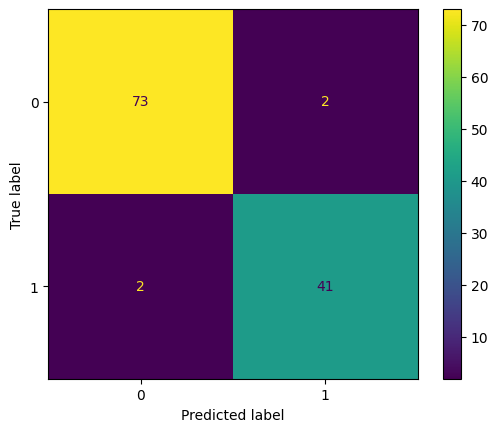

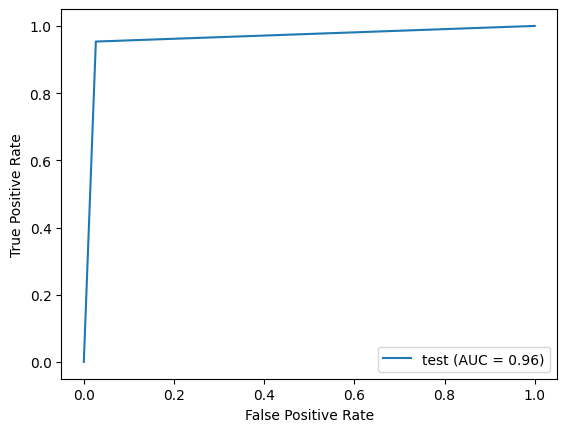

In [20]:
evaluate_on_all_datasets(inception_model)

### DenseNet

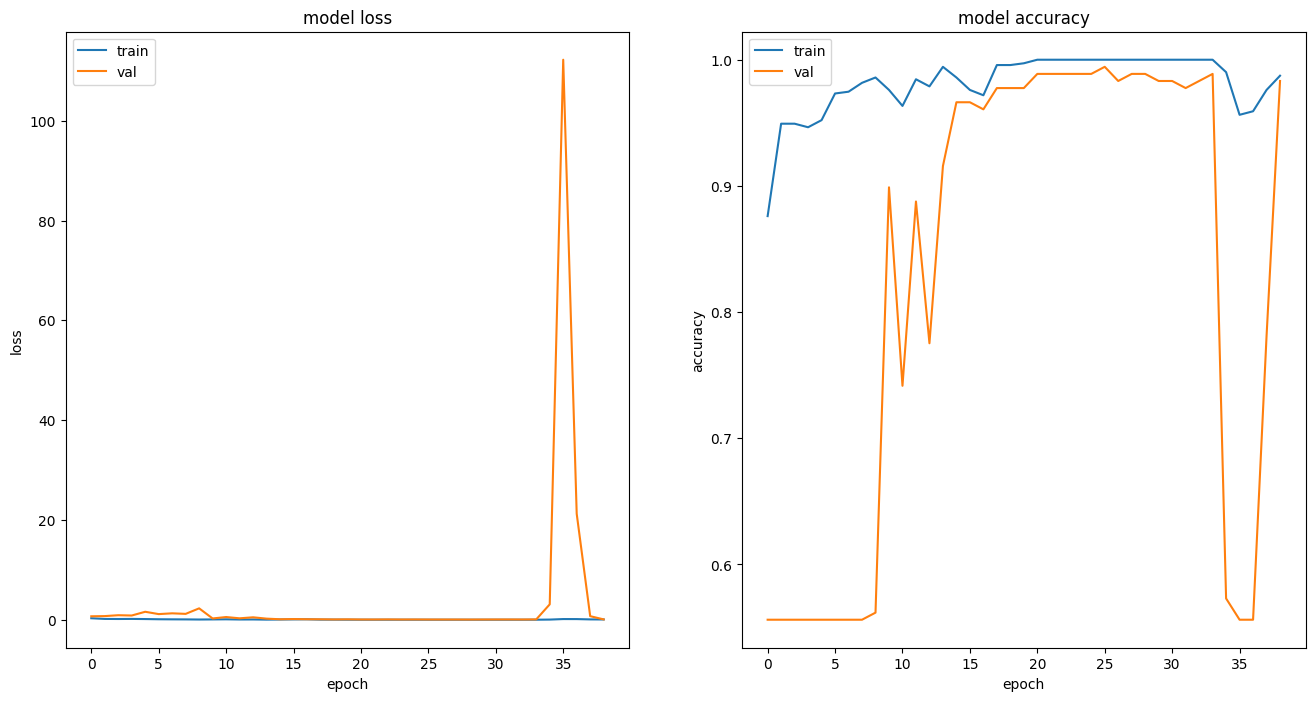

In [21]:
plot_loss_accuracy_curves(densenet_history, plot=True)

  0%|          | 0/45 [00:00<?, ?it/s]


----------------------------- Classification report for train dataset -----------------------------



,Metric,Score
0,Accuracy,1.0
1,Recall,1.0
2,Specificity,1.0
3,Precision,1.0
4,F1 Score,1.0


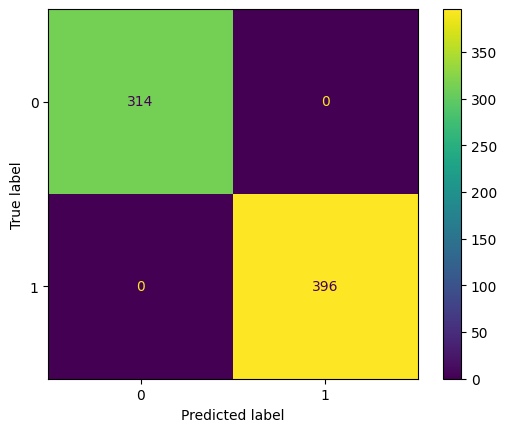

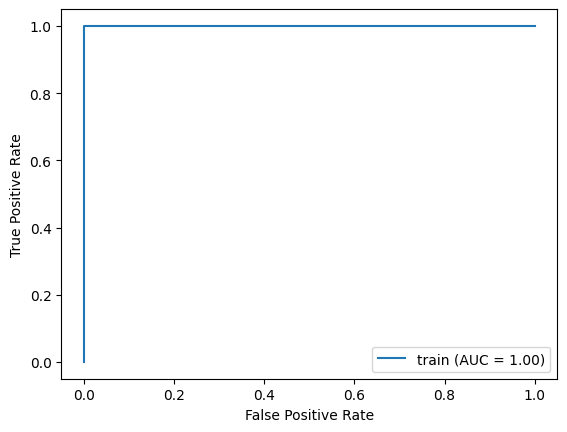

  0%|          | 0/12 [00:00<?, ?it/s]


----------------------------- Classification report for validation dataset -----------------------------



,Metric,Score
0,Accuracy,0.988764
1,Recall,1.000000
2,Specificity,0.974684
3,Precision,0.980198
4,F1 Score,0.990000


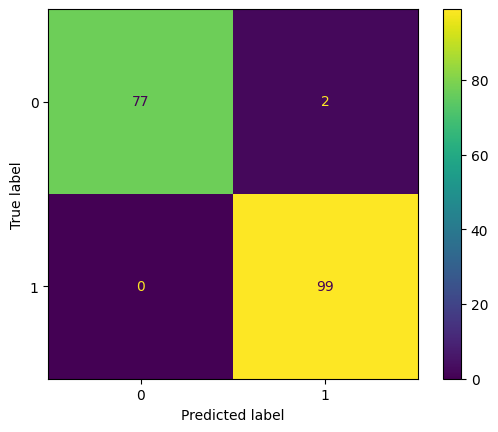

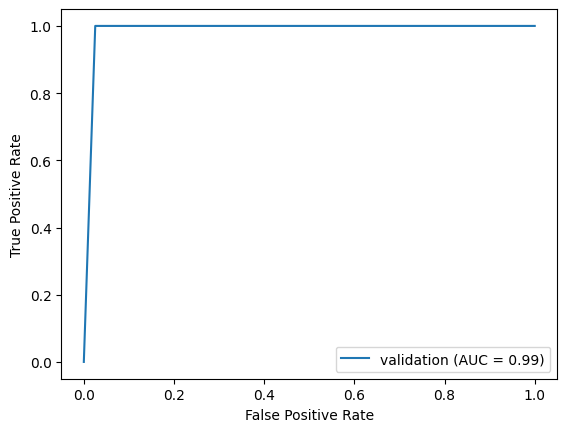

  0%|          | 0/8 [00:00<?, ?it/s]


----------------------------- Classification report for test dataset -----------------------------



,Metric,Score
0,Accuracy,0.966102
1,Recall,0.976744
2,Specificity,0.960000
3,Precision,0.933333
4,F1 Score,0.954545


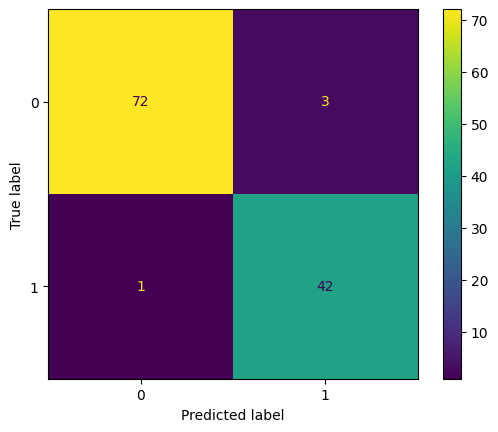

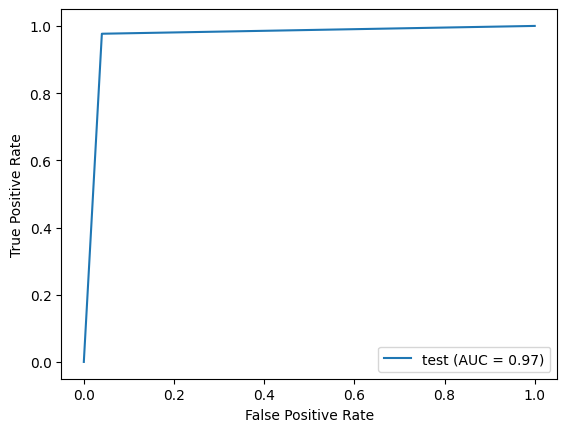

In [22]:
evaluate_on_all_datasets(densenet_model)

### ResNet

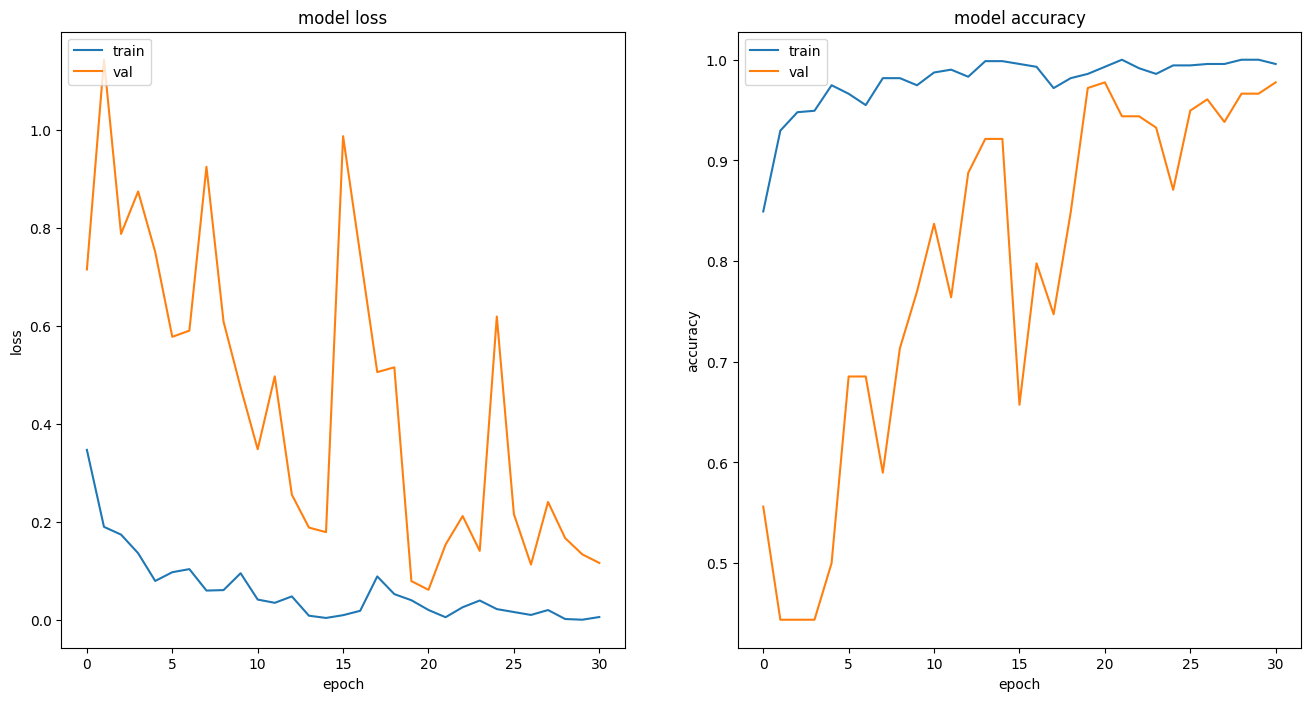

In [23]:
plot_loss_accuracy_curves(resnet_history, plot=True)

  0%|          | 0/45 [00:00<?, ?it/s]


----------------------------- Classification report for train dataset -----------------------------



,Metric,Score
0,Accuracy,0.976056
1,Recall,0.969697
2,Specificity,0.984076
3,Precision,0.987147
4,F1 Score,0.978344


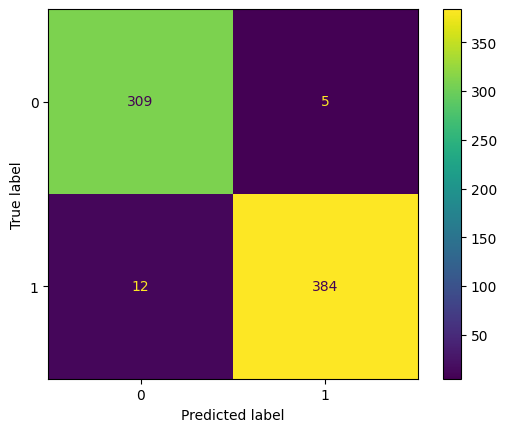

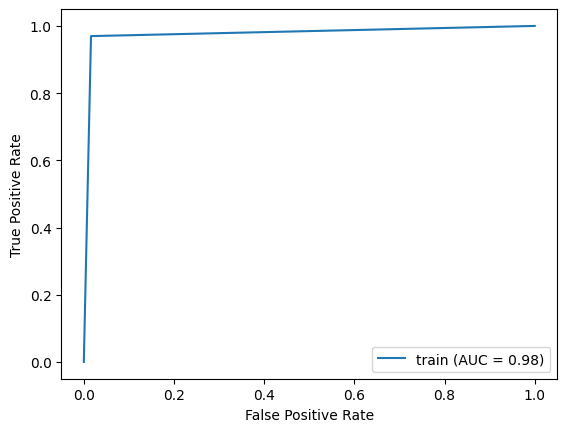

  0%|          | 0/12 [00:00<?, ?it/s]


----------------------------- Classification report for validation dataset -----------------------------



,Metric,Score
0,Accuracy,0.977528
1,Recall,0.969697
2,Specificity,0.987342
3,Precision,0.989691
4,F1 Score,0.979592


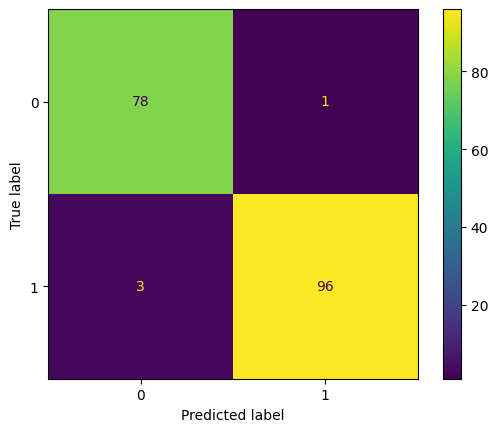

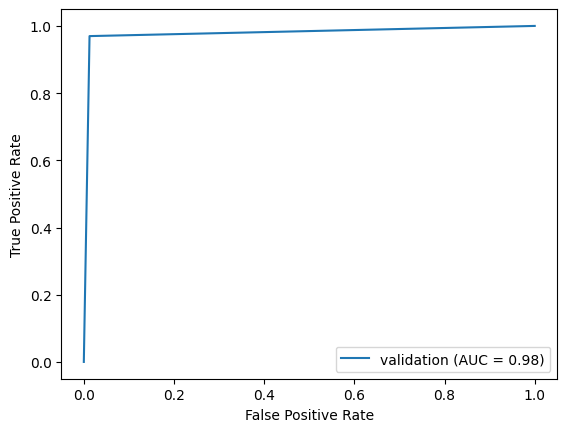

  0%|          | 0/8 [00:00<?, ?it/s]


----------------------------- Classification report for test dataset -----------------------------



,Metric,Score
0,Accuracy,0.957627
1,Recall,0.953488
2,Specificity,0.960000
3,Precision,0.931818
4,F1 Score,0.942529


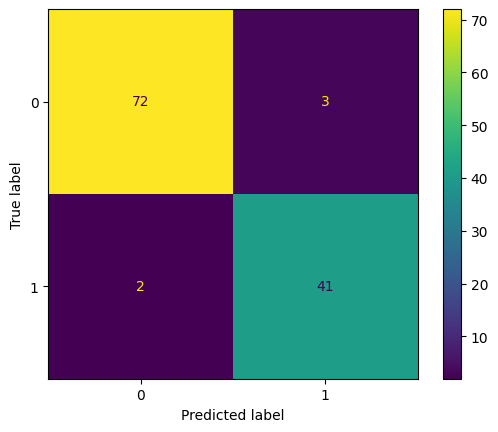

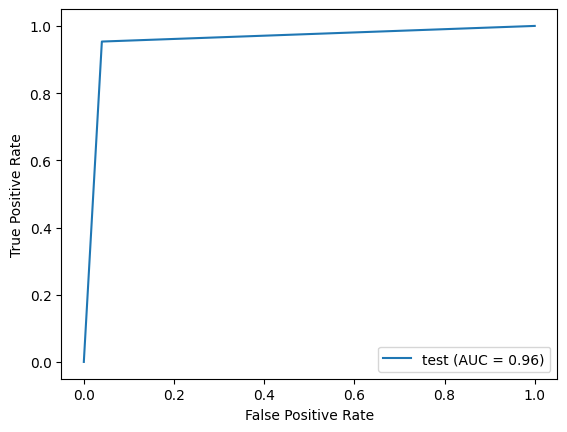

In [24]:
evaluate_on_all_datasets(resnet_model)

## Evaluate Ensemble 

In [25]:
def generate_weights(valid_batches, models):
    '''
    returns a list of weights
    '''
    accuracy = []
    weights = np.full((1, len(models)), 100.0)
    for model in models:
        acc = model.evaluate(valid_batches)[1]
        accuracy.append(100*acc)

    weights = weights - accuracy
    weights = weights**2
    sum = np.sum(weights)
    
    weights = weights/sum
    weights = 1/weights
    weights = weights**2

    sum = np.sum(weights)
    weights = weights/sum

    return weights

In [26]:
models = [densenet_model, resnet_model, inception_model]

w = generate_weights(valid_batches, models)[0]  # generating weights
print("Weights: ", w)

12/12 [==============================] - 7s 395ms/step - loss: 0.0768 - accuracy: 0.9831
Weights:  [0.79363135 0.04960196 0.15676669]


  0%|          | 0/45 [00:00<?, ?it/s]


----------------------------- Classification report for train dataset -----------------------------



,Metric,Score
0,Accuracy,1.0
1,Recall,1.0
2,Specificity,1.0
3,Precision,1.0
4,F1 Score,1.0


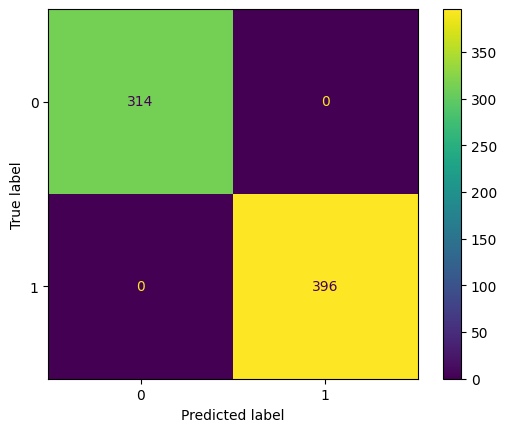

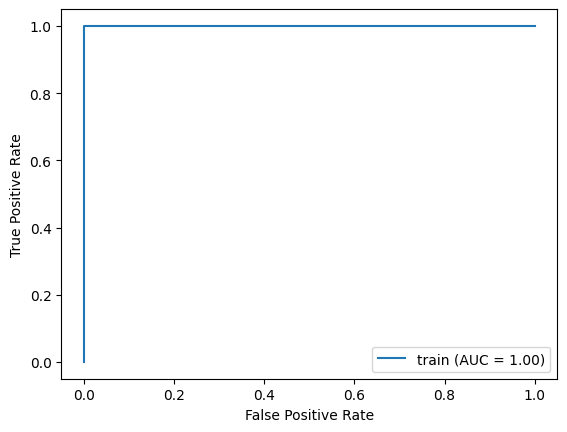

  0%|          | 0/12 [00:00<?, ?it/s]


----------------------------- Classification report for validation dataset -----------------------------



,Metric,Score
0,Accuracy,0.988764
1,Recall,1.000000
2,Specificity,0.974684
3,Precision,0.980198
4,F1 Score,0.990000


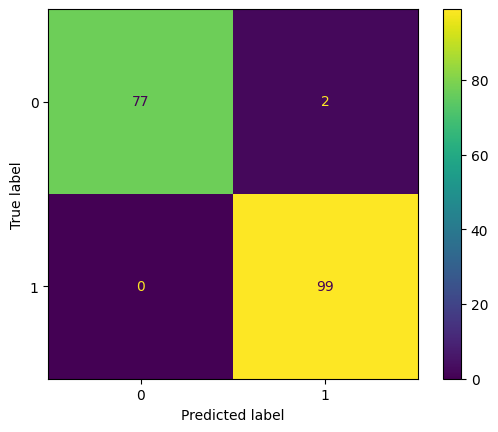

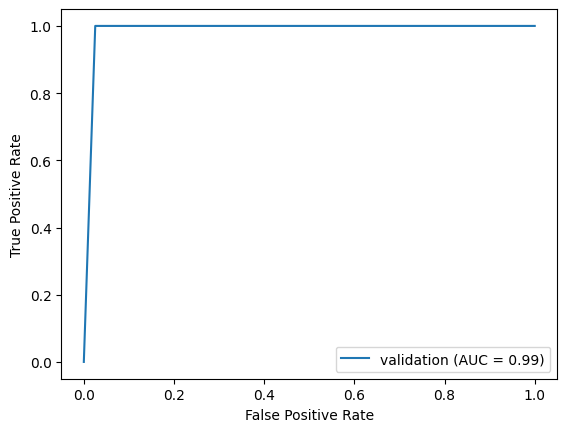

  0%|          | 0/8 [00:00<?, ?it/s]


----------------------------- Classification report for test dataset -----------------------------



,Metric,Score
0,Accuracy,0.974576
1,Recall,1.000000
2,Specificity,0.960000
3,Precision,0.934783
4,F1 Score,0.966292


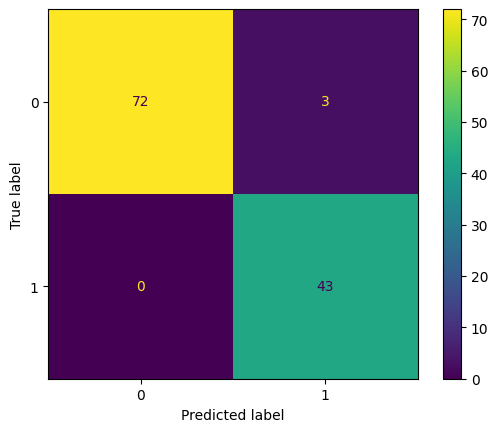

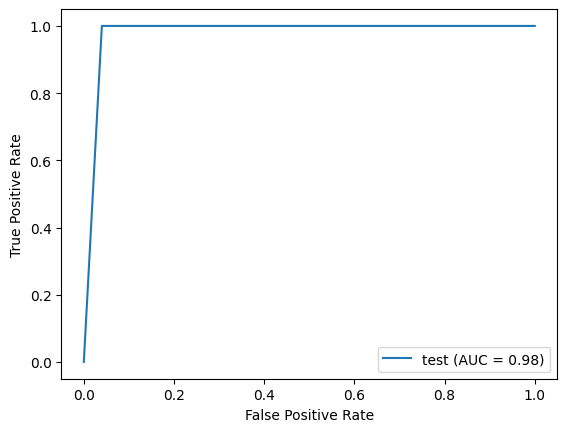

In [27]:
evaluate_on_all_datasets(models, ensemble=True, ensemble_weights=w)